In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [29]:
import numpy as np
import pylab as plt

from astropy.stats import sigma_clip

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from zernikies import getZernikeCoeffsOLS, getZernikeCoeffs
from utils.utils import midPoint, stride, rolling_std, gridLimits
from grid import regridXYZ, regridXYZMasked
from plotting import surface3dPlot, surfacePlot, barChartPlot
from lassiAnalysis import loadLeicaData, maskXYZ
from parabolas import fitLeicaData, rotateData, newParabola

In [3]:
n = 512
nZern = 36
guess = [60., 0., 0., -50., 0., 0.]
scanDir = '/home/scratch/psalas/LASSI/gpus/output/'
ref_scans = ['2020_03_16_02:21:06',
             '2020_03_16_02:54:59',
             '2020_03_16_03:19:50',
             '2020_03_16_03:44:25',
             '2020_03_16_04:09:06',
             '2020_03_16_04:33:33',
             '2020_03_16_04:58:03',
             '2020_03_16_05:22:24',
             '2020_03_16_05:47:09',
             '2020_03_16_06:11:20',
             '2020_03_16_06:35:42',
             '2020_03_16_07:00:20',
             '2020_03_16_07:24:39',
             '2020_03_16_07:48:47',
             '2020_03_16_08:12:50',
             '2020_03_16_08:37:03',
             '2020_03_16_09:01:35',
            ]

In [4]:
ref_scans[7]

'2020_03_16_05:22:24'

In [21]:
#sigScanFile = "{0}/2020_03_16_02:28:31.ptx.csv".format(scanDir) #C4=-516
#sigScanFile = "{0}/2020_03_16_06:43:17.ptx.csv".format(scanDir)
sigScanFile = "{0}/2020_03_16_04:16:39.ptx.csv".format(scanDir) #C7=-539
#sigScanFile = "{0}/2020_03_16_05:30:05.ptx.csv".format(scanDir) #C13=500
#sigScanFile = "{0}/2020_03_16_09:09:14.ptx.csv".format(scanDir) #C13=-536
iz = 7
izv = -539
orgData, cleanData = loadLeicaData(sigScanFile, n=n, numpy=False)
xs = orgData[0]
ys = orgData[1]
zs = orgData[2]

In [22]:
refScanFile = "{0}/{1}.ptx.csv".format(scanDir, ref_scans[7])
orgData, cleanData = loadLeicaData(refScanFile, n=n, numpy=False)
xr = orgData[0]
yr = orgData[1]
zr = orgData[2]

In [23]:
xmin, xmax = gridLimits(xs, xr)
ymin, ymax = gridLimits(ys, yr)

xrg, yrg, zrg = regridXYZ(xr, yr, zr, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
xsg, ysg, zsg = regridXYZ(xs, ys, zs, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

diff = zsg - zrg
diff = sigma_clip(diff)

<IPython.core.display.Javascript object>


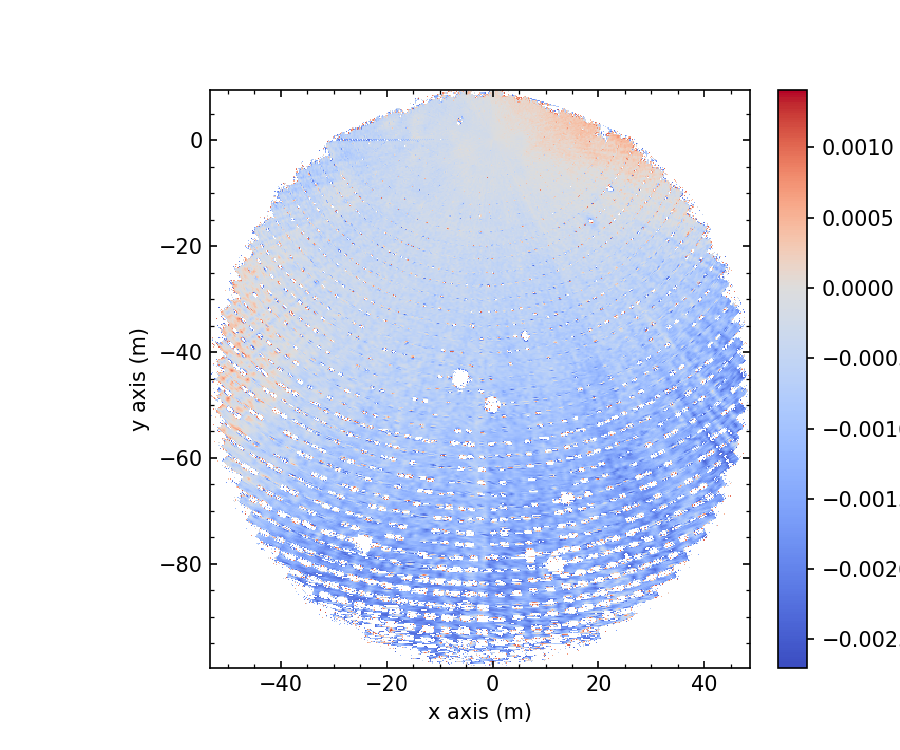

In [24]:
vmin = np.nanmin(diff)
vmax = np.nanmax(diff)
surfacePlot(xrg, yrg, sigma_clip(diff).T, vMin=vmin, vMax=vmax)

In [25]:
# Use WLS to determine the Zernike coefficients.
dz_s = stride(diff.filled(np.nan), r_c=(4,4))
dz_std = rolling_std(dz_s, no_null=False)
dz_std_pad = np.pad(dz_std, ((2,1),(2,1)), mode='constant', constant_values=np.nan)
dz_std_pad = np.ma.masked_where(dz_std_pad <= 20e-6, dz_std_pad)
w = np.power(dz_std_pad, -2.)
w = np.ma.masked_invalid(w)
x_ = np.ma.masked_invalid(xrg-midPoint(xrg))
y_ = np.ma.masked_invalid(yrg-midPoint(yrg))
fl_wls = getZernikeCoeffsOLS(x_, y_, diff, nZern, weights=w)

/home/scratch/psalas/LASSI/lassi-analysis_v2/psalas_lassi_env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/scratch/psalas/LASSI/lassi-analysis_v2/psalas_lassi_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less_equal
  """
/home/scratch/psalas/LASSI/lassi-analysis_v2/psalas_lassi_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in power
  


<IPython.core.display.Javascript object>


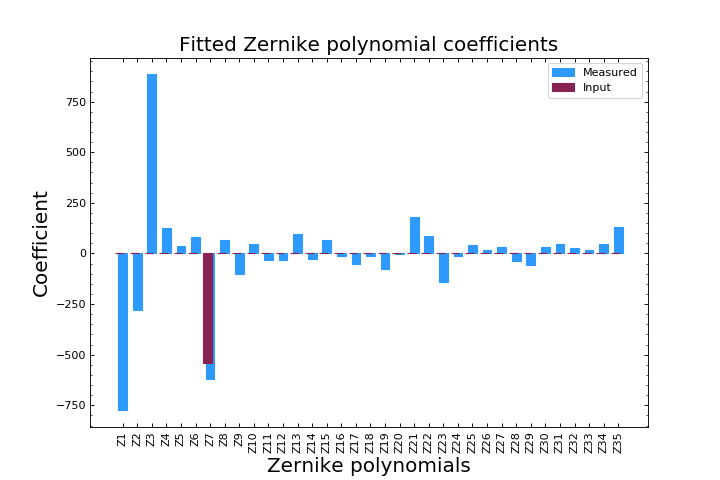

-622.0685481101499


In [26]:
expected = np.zeros(37)
expected[iz] = izv
barChartPlot(np.arange(1,36), fl_wls[1:36]*1e6, expected=expected[1:36])
print((fl_wls*1e6)[iz])

In [27]:
fitlist = getZernikeCoeffs(diff.filled(0)[::-1].T, nZern, norm='active-surface')

<IPython.core.display.Javascript object>


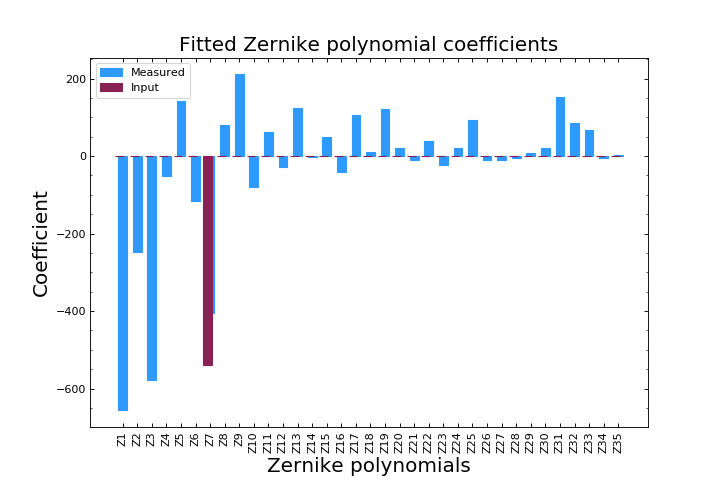

-404.0221369638328


In [28]:
barChartPlot(np.arange(1,36), np.asarray(fitlist[1:36])*1e6, expected=expected[1:36])
print((fitlist)[iz]*1e6)